# LLaMA 3 8B Text Classification With QLoRA 

In [26]:
import pandas as pd
import numpy as np
import torch
import json
import wandb
from transformers import BitsAndBytesConfig, AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, DataCollatorWithPadding, Trainer
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, classification_report
from datasets import Dataset, DatasetDict
import datetime
import torch.nn.functional as F

In [27]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

run = wandb.init(
    project='wz_llama_classifier_finetuned',
    config={"model_name": "Meta-Llama-3-8B"}
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [28]:
id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

In [29]:
train = pd.read_csv('../datasets/archived/em_train.csv')
test = pd.read_csv('../datasets/archived/em_test.csv')
validation = pd.read_csv('../datasets/archived/em_val.csv')

train['level'] = train['label'].apply(lambda x: id_to_label_mapping[x])
test['level'] = test['label'].apply(lambda x: id_to_label_mapping[x])
validation['level'] = validation['label'].apply(lambda x: id_to_label_mapping[x])

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
validation = validation.sample(frac=1).reset_index(drop=True)

In [30]:
train.head()

,no,text,label,level
0,8756,ive made it through a week i just feel beaten ...,0,A1
1,4660,i feel this strategy is worthwhile,1,A2
2,6095,i feel so worthless and weak what does he have...,0,A1
3,304,i feel clever nov,1,A2
4,8241,im moved in ive been feeling kind of gloomy,0,A1


In [31]:
test.head()

,no,text,label,level
0,1305,i do feel apprehensive and nervous at times ab...,4,C1
1,634,i feels so lame,0,A1
2,1789,i to feel unwelcome at her apartment certainly...,0,A1
3,450,i sit here feeling drained i really wonder wha...,0,A1
4,162,i feel slightly relaxed being a,1,A2


In [32]:
validation.head()

,no,text,label,level
0,1413,im feeling a little apprehensive as we come ne...,4,C1
1,531,i don t feel too troubled about this,0,A1
2,1880,i feel confident that you and i have something...,1,A2
3,1587,i owned yet did not feel fully welcomed i deci...,1,A2
4,573,i feel like ive been running around without an...,2,B1


In [33]:
print(train["text"].str.len().max())
print(test["text"].str.len().max())
print(validation["text"].str.len().max())

300
296
295


In [34]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train),
    'val': Dataset.from_pandas(validation),
    'test': Dataset.from_pandas(test)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['no', 'text', 'label', 'level'],
        num_rows: 16000
    })
    val: Dataset({
        features: ['no', 'text', 'label', 'level'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['no', 'text', 'label', 'level'],
        num_rows: 2000
    })
})

In [35]:
class_weights=(1/train.label.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights

tensor([0.0550, 0.0479, 0.1969, 0.1189, 0.1325, 0.4488])

In [36]:
model_name = "meta-llama/Meta-Llama-3-8B"

In [37]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = 'nf4',
    bnb_4bit_use_double_quant = False,
    bnb_4bit_compute_dtype = torch.float16
)

In [38]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules = ['down_proj', 'gate_proj', 'o_proj', 'v_proj', 'up_proj', 'q_proj', 'k_proj'],
    bias = 'none',
    task_type = 'SEQ_CLS'
)

In [39]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=6,
    device_map=None,
    resume_download=None,
    low_cpu_mem_usage=True
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
model = prepare_model_for_kbit_training(model)

In [41]:
model = get_peft_model(model, lora_config)

In [42]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    resume_download=None,
    add_prefix_space=True
)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [43]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model.config.pad_token_id = model.config.eos_token_id

In [44]:
MAX_LEN = 350
col_to_delete = ['text']

def llama_preprocessing_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [45]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [46]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}

In [47]:
class CustomTrainer(Trainer):
    def __init__(self, *arguments, c_weights=None, **kwargs):
        super().__init__(*arguments, **kwargs)
        
        if c_weights is not None:
            self.class_weights = torch.tensor(c_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, c_model, c_inputs, return_outputs=False):
        labels = c_inputs.pop("labels").long()

        outputs = c_model(**c_inputs)

        logits = outputs.get('logits')

        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [48]:
training_args = TrainingArguments(
    output_dir = 'model',
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs = 2,
    report_to="wandb",
    logging_dir='model',
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

# training_arguments = TrainingArguments(
#     output_dir= 'model',
#     num_train_epochs=1,
#     per_device_train_batch_size=1,
#     gradient_accumulation_steps=8,
#     gradient_checkpointing=True,
#     optim="paged_adamw_32bit",
#     logging_steps=1,
#     learning_rate=2e-4,
#     weight_decay=0.001,
#     fp16=True,
#     bf16=False,
#     max_grad_norm=0.3,
#     max_steps=-1,
#     warmup_ratio=0.03,
#     group_by_length=False,
#     lr_scheduler_type="cosine",
#     report_to="wandb",
#     eval_steps = 0.2
# )


In [49]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'].shuffle(seed=42),
    eval_dataset = tokenized_datasets['val'].shuffle(seed=42),
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics
)

In [50]:
train_result = trainer.train()

C:\Users\kawis\anaconda3\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\kawis\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Accuracy
1,0.526800,0.197809,0.913807,0.935500
2,0.110100,0.103603,0.920774,0.945000


C:\Users\kawis\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\kawis\anaconda3\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\kawis\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocas

In [51]:
model.config.use_cache = True

In [52]:
trainer.save_model('model')
tokenizer.save_pretrained('model')

C:\Users\kawis\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


('model\\tokenizer_config.json',
 'model\\special_tokens_map.json',
 'model\\tokenizer.json')

In [53]:
def make_predictions(p_model, p_test):
    print(f'Started prediction at {datetime.datetime.now()}')
    sentences = p_test.text.tolist()

    batch_size = 32 

    all_outputs = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]

        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

        inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

        with torch.no_grad():
            outputs = p_model(**inputs)
            all_outputs.append(outputs['logits'])
            
    final_outputs = torch.cat(all_outputs, dim=0)
    p_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
    p_test['predictions']=p_test['predictions'].apply(lambda l:id_to_label_mapping[l])


make_predictions(model,test)

Started prediction at 2024-08-15 03:22:21.135871


Accuracy: 0.931
Accuracy for label A1: 0.964
Accuracy for label A2: 0.961
Accuracy for label B1: 0.843
Accuracy for label B2: 0.942
Accuracy for label C1: 0.875
Accuracy for label C2: 0.682

Classification Report:
              precision    recall  f1-score   support

          A1       0.98      0.96      0.97       581
          A2       0.95      0.96      0.96       695
          B1       0.85      0.84      0.85       159
          B2       0.92      0.94      0.93       275
          C1       0.89      0.88      0.88       224
          C2       0.71      0.68      0.70        66

    accuracy                           0.93      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000


Confusion Matrix:
[[560   2   0  14   5   0]
 [  0 668  23   0   1   3]
 [  1  24 134   0   0   0]
 [  8   2   0 259   6   0]
 [  4   0   0   9 196  15]
 [  1   7   0   0  13  45]]


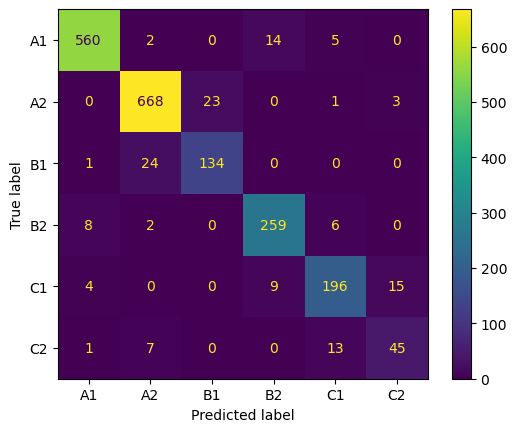

In [54]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = test['predictions']

y_true = test['level']

def map_func(x):
    return label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

# Generate accuracy report
unique_labels = set(y_true_mapped)  # Get unique labels

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)
print('\nClassification Report:')
print(class_report)
table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        # For accuracy, add precision and recall as 0
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(train['level'], test['level'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

In [55]:
print(f'Ended prediction at {datetime.datetime.now()}')
wandb.finish()

Ended prediction at 2024-08-15 03:25:02.079613


eval/accuracy,▁█
eval/balanced_accuracy,▁█
eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,▁▁
train/epoch,▁▁███
train/global_step,▁▁█████
train/grad_norm,█▁
train/learning_rate,█▁
train/loss,█▁
